In [1]:
!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn import metrics

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATES = [0.001, 0.01, 0.1]
MOMENTUM_VALUES = [0.9, 0.95, 0.99]
WEIGHT_DECAYS = [0.0001, 0.001, 0.01]
RANDOM_SEARCH_TRIALS = 10

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
print(DataClass)

<class 'medmnist.dataset.BreastMNIST'>


In [5]:
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

device = get_device()
print(device)

cuda


## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])


# Load the original dataset
original_dataset = medmnist.dataset.BreastMNIST(split='train', transform=data_transform, download=download)


# Calculate the sizes for training and validation sets
total_size = len(original_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Split the dataset into training and validation sets
train_dataset, validation_dataset = data.random_split(original_dataset, [train_size, val_size])

# # load the data
# train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz


In [7]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: C:\Users\zayaa\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0


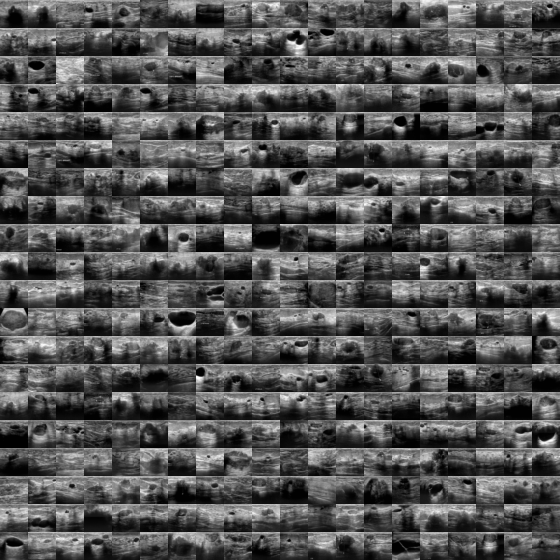

In [8]:
# montage

original_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [9]:
import torch
import torchvision.models as models
import torch.nn as nn

resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

class ExtendedNetwork(nn.Module):
    def __init__(self, original_model):
        super(ExtendedNetwork, self).__init__()
        # extracting all layers/features until the last layer to allow for edits
        every_layer_not_last = original_model.children()
        self.features = nn.Sequential(*list(every_layer_not_last))[:-1]

        self.new_layers = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Dropout(0.1),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.new_layers(x)
        return x

network = ExtendedNetwork(resnet18)
network.to(device=device)
# feature_list = [feature for feature in network.features.children()]
# print(feature_list)
print(network)

c:\Users\zayaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zayaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ExtendedNetwork(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [10]:
def accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total

## Next, we can start to train and evaluate!

Trial 1/10
TESTING ON HYPERPARAMETERS: Learning Rate: 0.1, Momentum: 0.99, Weight Decay: 0.0001



(Train) Epoch: 0 on cuda: 100%|██████████| 7/7 [00:00<00:00, 10.37it/s]


Train - Loss: 0.029191, Accuracy: 52.76% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 33.16it/s]


Validation - Loss: 0.012755, Accuracy: 72.11% 



(Train) Epoch: 1 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.61it/s]


Train - Loss: 0.006397, Accuracy: 63.60% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 55.86it/s]


Validation - Loss: 0.012755, Accuracy: 72.11% 



(Train) Epoch: 2 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.64it/s]


Train - Loss: 0.005902, Accuracy: 69.42% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 58.31it/s]


Validation - Loss: 0.012772, Accuracy: 72.11% 



(Train) Epoch: 3 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.53it/s]


Train - Loss: 0.004120, Accuracy: 70.43% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 52.41it/s]


Validation - Loss: 0.012945, Accuracy: 61.99% 



(Train) Epoch: 4 on cuda: 100%|██████████| 7/7 [00:00<00:00, 26.59it/s]


Train - Loss: 0.003062, Accuracy: 68.90% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 61.32it/s]


Validation - Loss: 0.012758, Accuracy: 72.11% 

Trial 2/10
TESTING ON HYPERPARAMETERS: Learning Rate: 0.01, Momentum: 0.99, Weight Decay: 0.0001



(Train) Epoch: 0 on cuda: 100%|██████████| 7/7 [00:00<00:00, 22.42it/s]


Train - Loss: 0.002299, Accuracy: 73.39% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 27.36it/s]


Validation - Loss: 0.012799, Accuracy: 72.11% 



(Train) Epoch: 1 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.36it/s]


Train - Loss: 0.002287, Accuracy: 73.28% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 59.69it/s]


Validation - Loss: 0.012867, Accuracy: 72.11% 



(Train) Epoch: 2 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.31it/s]


Train - Loss: 0.002066, Accuracy: 73.44% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 55.17it/s]


Validation - Loss: 0.012779, Accuracy: 72.11% 



(Train) Epoch: 3 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.94it/s]


Train - Loss: 0.002107, Accuracy: 73.33% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 53.04it/s]


Validation - Loss: 0.012879, Accuracy: 72.11% 



(Train) Epoch: 4 on cuda: 100%|██████████| 7/7 [00:00<00:00, 23.41it/s]


Train - Loss: 0.002017, Accuracy: 72.54% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 49.43it/s]


Validation - Loss: 0.012813, Accuracy: 72.11% 

Trial 3/10
TESTING ON HYPERPARAMETERS: Learning Rate: 0.1, Momentum: 0.9, Weight Decay: 0.001



(Train) Epoch: 0 on cuda: 100%|██████████| 7/7 [00:00<00:00, 23.31it/s]


Train - Loss: 0.031378, Accuracy: 64.63% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 63.54it/s]


Validation - Loss: 0.013592, Accuracy: 27.89% 



(Train) Epoch: 1 on cuda: 100%|██████████| 7/7 [00:00<00:00, 22.66it/s]


Train - Loss: 0.016677, Accuracy: 60.89% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 54.83it/s]


Validation - Loss: 0.012755, Accuracy: 72.11% 



(Train) Epoch: 2 on cuda: 100%|██████████| 7/7 [00:00<00:00, 23.04it/s]


Train - Loss: 0.012668, Accuracy: 67.07% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 54.90it/s]


Validation - Loss: 0.013049, Accuracy: 72.11% 



(Train) Epoch: 3 on cuda: 100%|██████████| 7/7 [00:00<00:00, 19.94it/s]


Train - Loss: 0.007948, Accuracy: 65.16% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 58.54it/s]


Validation - Loss: 0.012762, Accuracy: 72.11% 



(Train) Epoch: 4 on cuda: 100%|██████████| 7/7 [00:00<00:00, 26.06it/s]


Train - Loss: 0.003837, Accuracy: 68.20% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 56.36it/s]


Validation - Loss: 0.012839, Accuracy: 72.11% 

Trial 4/10
TESTING ON HYPERPARAMETERS: Learning Rate: 0.1, Momentum: 0.99, Weight Decay: 0.01



(Train) Epoch: 0 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.64it/s]


Train - Loss: 0.012361, Accuracy: 62.28% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 60.08it/s]


Validation - Loss: 0.012775, Accuracy: 72.11% 



(Train) Epoch: 1 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.39it/s]


Train - Loss: 0.006271, Accuracy: 70.36% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 33.39it/s]


Validation - Loss: 0.012764, Accuracy: 72.11% 



(Train) Epoch: 2 on cuda: 100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


Train - Loss: 0.005605, Accuracy: 62.28% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 54.82it/s]


Validation - Loss: 0.012760, Accuracy: 72.11% 



(Train) Epoch: 3 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.15it/s]


Train - Loss: 0.002472, Accuracy: 70.98% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 54.65it/s]


Validation - Loss: 0.012776, Accuracy: 72.11% 



(Train) Epoch: 4 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.18it/s]


Train - Loss: 0.002493, Accuracy: 70.96% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 66.95it/s]


Validation - Loss: 0.012756, Accuracy: 72.11% 

Trial 5/10
TESTING ON HYPERPARAMETERS: Learning Rate: 0.001, Momentum: 0.99, Weight Decay: 0.001



(Train) Epoch: 0 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.62it/s]


Train - Loss: 0.002636, Accuracy: 73.49% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 36.73it/s]


Validation - Loss: 0.012783, Accuracy: 72.11% 



(Train) Epoch: 1 on cuda: 100%|██████████| 7/7 [00:00<00:00, 23.54it/s]


Train - Loss: 0.001827, Accuracy: 74.28% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 63.40it/s]


Validation - Loss: 0.012832, Accuracy: 72.11% 



(Train) Epoch: 2 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.92it/s]


Train - Loss: 0.001668, Accuracy: 78.45% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 65.19it/s]


Validation - Loss: 0.012808, Accuracy: 72.11% 



(Train) Epoch: 3 on cuda: 100%|██████████| 7/7 [00:00<00:00, 21.62it/s]


Train - Loss: 0.001622, Accuracy: 77.95% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 55.09it/s]


Validation - Loss: 0.012776, Accuracy: 72.11% 



(Train) Epoch: 4 on cuda: 100%|██████████| 7/7 [00:00<00:00, 20.85it/s]


Train - Loss: 0.001420, Accuracy: 80.51% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 53.64it/s]


Validation - Loss: 0.012773, Accuracy: 72.11% 

Trial 6/10
TESTING ON HYPERPARAMETERS: Learning Rate: 0.01, Momentum: 0.95, Weight Decay: 0.0001



(Train) Epoch: 0 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.10it/s]


Train - Loss: 0.002239, Accuracy: 71.48% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 53.68it/s]


Validation - Loss: 0.013586, Accuracy: 27.89% 



(Train) Epoch: 1 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.31it/s]


Train - Loss: 0.001798, Accuracy: 74.93% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 54.50it/s]


Validation - Loss: 0.013451, Accuracy: 34.27% 



(Train) Epoch: 2 on cuda: 100%|██████████| 7/7 [00:00<00:00, 23.43it/s]


Train - Loss: 0.001706, Accuracy: 77.28% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 47.62it/s]


Validation - Loss: 0.012956, Accuracy: 60.60% 



(Train) Epoch: 3 on cuda: 100%|██████████| 7/7 [00:00<00:00, 21.68it/s]


Train - Loss: 0.001701, Accuracy: 77.06% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 55.38it/s]


Validation - Loss: 0.012704, Accuracy: 74.59% 



(Train) Epoch: 4 on cuda: 100%|██████████| 7/7 [00:00<00:00, 22.93it/s]


Train - Loss: 0.001527, Accuracy: 79.17% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 52.17it/s]


Validation - Loss: 0.012755, Accuracy: 72.11% 

Trial 7/10
TESTING ON HYPERPARAMETERS: Learning Rate: 0.1, Momentum: 0.95, Weight Decay: 0.001



(Train) Epoch: 0 on cuda: 100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


Train - Loss: 0.023006, Accuracy: 57.37% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 50.52it/s]


Validation - Loss: 0.012755, Accuracy: 72.11% 



(Train) Epoch: 1 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.48it/s]


Train - Loss: 0.004474, Accuracy: 67.10% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 60.36it/s]


Validation - Loss: 0.012755, Accuracy: 72.11% 



(Train) Epoch: 2 on cuda: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]


Train - Loss: 0.004073, Accuracy: 65.57% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 55.44it/s]


Validation - Loss: 0.012755, Accuracy: 72.11% 



(Train) Epoch: 3 on cuda: 100%|██████████| 7/7 [00:00<00:00, 22.93it/s]


Train - Loss: 0.003768, Accuracy: 70.33% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 58.12it/s]


Validation - Loss: 0.012839, Accuracy: 71.33% 



(Train) Epoch: 4 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.06it/s]


Train - Loss: 0.003758, Accuracy: 63.96% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 65.11it/s]


Validation - Loss: 0.012755, Accuracy: 72.11% 

Trial 8/10
TESTING ON HYPERPARAMETERS: Learning Rate: 0.1, Momentum: 0.95, Weight Decay: 0.01



(Train) Epoch: 0 on cuda: 100%|██████████| 7/7 [00:00<00:00, 20.94it/s]


Train - Loss: 0.004338, Accuracy: 51.77% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 50.74it/s]


Validation - Loss: 0.012890, Accuracy: 72.11% 



(Train) Epoch: 1 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.29it/s]


Train - Loss: 0.003725, Accuracy: 65.88% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 60.92it/s]


Validation - Loss: 0.012794, Accuracy: 72.11% 



(Train) Epoch: 2 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.49it/s]


Train - Loss: 0.002167, Accuracy: 73.33% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 52.80it/s]


Validation - Loss: 0.012942, Accuracy: 72.11% 



(Train) Epoch: 3 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.06it/s]


Train - Loss: 0.002699, Accuracy: 63.67% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 60.14it/s]


Validation - Loss: 0.012803, Accuracy: 72.11% 



(Train) Epoch: 4 on cuda: 100%|██████████| 7/7 [00:00<00:00, 22.65it/s]


Train - Loss: 0.002156, Accuracy: 73.33% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 65.31it/s]


Validation - Loss: 0.012851, Accuracy: 72.11% 

Trial 9/10
TESTING ON HYPERPARAMETERS: Learning Rate: 0.01, Momentum: 0.99, Weight Decay: 0.0001



(Train) Epoch: 0 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.34it/s]


Train - Loss: 0.002105, Accuracy: 70.21% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 62.42it/s]


Validation - Loss: 0.012765, Accuracy: 72.11% 



(Train) Epoch: 1 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.86it/s]


Train - Loss: 0.001750, Accuracy: 75.55% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 45.40it/s]


Validation - Loss: 0.012756, Accuracy: 72.11% 



(Train) Epoch: 2 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.54it/s]


Train - Loss: 0.001615, Accuracy: 75.50% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 27.63it/s]


Validation - Loss: 0.012745, Accuracy: 72.11% 



(Train) Epoch: 3 on cuda: 100%|██████████| 7/7 [00:00<00:00, 23.02it/s]


Train - Loss: 0.001629, Accuracy: 76.12% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 61.69it/s]


Validation - Loss: 0.012705, Accuracy: 74.76% 



(Train) Epoch: 4 on cuda: 100%|██████████| 7/7 [00:00<00:00, 25.22it/s]


Train - Loss: 0.001519, Accuracy: 80.56% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 48.41it/s]


Validation - Loss: 0.012753, Accuracy: 72.11% 

Trial 10/10
TESTING ON HYPERPARAMETERS: Learning Rate: 0.001, Momentum: 0.95, Weight Decay: 0.01



(Train) Epoch: 0 on cuda: 100%|██████████| 7/7 [00:00<00:00, 22.48it/s]


Train - Loss: 0.001323, Accuracy: 82.80% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 49.17it/s]


Validation - Loss: 0.012719, Accuracy: 72.89% 



(Train) Epoch: 1 on cuda: 100%|██████████| 7/7 [00:00<00:00, 20.84it/s]


Train - Loss: 0.001343, Accuracy: 83.64% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 65.13it/s]


Validation - Loss: 0.012767, Accuracy: 72.11% 



(Train) Epoch: 2 on cuda: 100%|██████████| 7/7 [00:00<00:00, 24.82it/s]


Train - Loss: 0.001387, Accuracy: 83.74% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 44.23it/s]


Validation - Loss: 0.012788, Accuracy: 72.11% 



(Train) Epoch: 3 on cuda: 100%|██████████| 7/7 [00:00<00:00, 21.98it/s]


Train - Loss: 0.001416, Accuracy: 83.34% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 59.13it/s]


Validation - Loss: 0.012795, Accuracy: 72.11% 



(Train) Epoch: 4 on cuda: 100%|██████████| 7/7 [00:00<00:00, 23.63it/s]


Train - Loss: 0.001448, Accuracy: 83.57% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 39.64it/s]


Validation - Loss: 0.012792, Accuracy: 72.11% 


Best Hyperparameters:
{'learning_rate': 0.001, 'momentum': 0.95, 'weight_decay': 0.01}
Best Training Accuracy: 83.74%
Best Validation Accuracy: 74.76%


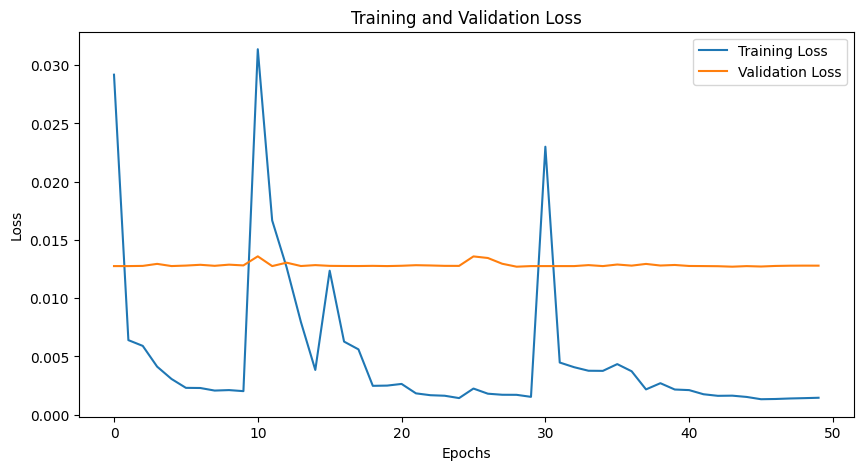

In [11]:
import matplotlib.pyplot as plt

# train

loss_function = nn.BCEWithLogitsLoss() # Each sample belongs to one of two classes (0 or 1) so we can use this loss function.

best_train_accuracy = 0
best_val_accuracy = 0
best_hyperparameters = {}

# Lists to store average losses
avg_train_losses = []
avg_val_losses = []

for trial in range(RANDOM_SEARCH_TRIALS):
    print(f"Trial {trial + 1}/{RANDOM_SEARCH_TRIALS}")

    learning_rate = np.random.choice(LEARNING_RATES)
    momentum = np.random.choice(MOMENTUM_VALUES)
    weight_decay = np.random.choice(WEIGHT_DECAYS)

    print(f"TESTING ON HYPERPARAMETERS: Learning Rate: {learning_rate}, Momentum: {momentum}, Weight Decay: {weight_decay}\n")

    optimizer = optim.Adam(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(NUM_EPOCHS):
        train_correct = 0
        train_total = 0
        test_correct = 0
        test_total = 0
        # running loss and acurracy
        running_loss = 0.0
        running_accuracy = 0.0

        network.train()
        for inputs, targets in tqdm(train_loader, desc="(Train) Epoch: " + str(epoch) + " on " + str(device)):
            # forward + backward + optimize
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = network(inputs)

            targets = targets.squeeze().long()
            targets_one_hot = torch.nn.functional.one_hot(targets.long(), num_classes=10).float()
            targets_one_hot = targets_one_hot.squeeze(1)
            
            # Call Loss function
            binary_cross_entropy_loss = loss_function(outputs, targets_one_hot)

            # Call Backward function
            binary_cross_entropy_loss.backward()

            optimizer.step()

            running_loss += binary_cross_entropy_loss.item() / len(inputs)
            running_accuracy += accuracy(outputs, targets)
        
        epoch_loss = running_loss / len(train_loader)
        avg_train_losses.append(epoch_loss)

        print("Train - Loss: {:.6f}, Accuracy: {:.2f}%".format(epoch_loss, running_accuracy / len(train_loader) * 100), "\n")

        # Validation
        network.eval()
        val_running_loss = 0.0
        val_running_accuracy = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in tqdm(validation_loader, desc="(Validation) Epoch: " + str(epoch) + " on " + str(device)):
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = network(val_inputs)

                val_outputs = F.softmax(val_outputs, dim=1)

                val_targets = val_targets.squeeze().long()
                val_targets_one_hot = torch.nn.functional.one_hot(val_targets.long(), num_classes=10).float()
                val_targets_one_hot = val_targets_one_hot.squeeze(1)

                val_loss = loss_function(val_outputs, val_targets_one_hot)

                val_running_loss += val_loss.item() / len(val_inputs)
                val_running_accuracy += accuracy(val_outputs, val_targets)

        val_epoch_loss = val_running_loss / len(validation_loader)
        avg_val_losses.append(val_epoch_loss)

        print("Validation - Loss: {:.6f}, Accuracy: {:.2f}%".format(val_epoch_loss, val_running_accuracy / len(validation_loader) * 100), "\n")

        # Check if this trial has the best accuracy
        if running_accuracy > best_train_accuracy:
            best_train_accuracy = running_accuracy
            best_hyperparameters = {
                "learning_rate": learning_rate,
                "momentum": momentum,
                "weight_decay": weight_decay
            }
        if val_running_accuracy > best_val_accuracy:
            best_val_accuracy = val_running_accuracy

# Print the best hyperparameters and accuracy
print("\nBest Hyperparameters:")
print(best_hyperparameters)
print("Best Training Accuracy: {:.2f}%".format(best_train_accuracy / len(train_loader) * 100))
print("Best Validation Accuracy: {:.2f}%".format(best_val_accuracy / len(validation_loader) * 100))

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


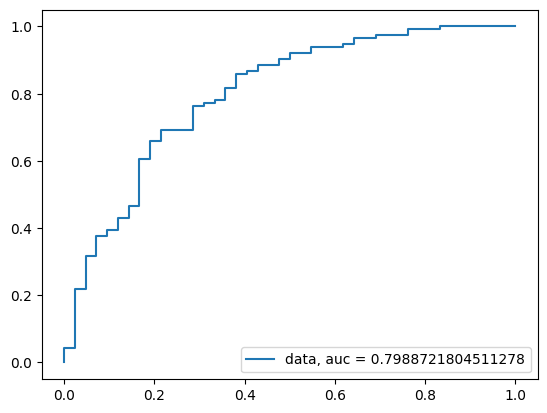

In [12]:
# switching the network to evaluation mode
network.eval()

y_test = []
y_score = []

for inputs, targets in test_loader:
    # Send the data to the GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Call the forward function
    outputs = network(inputs)

    # Apply softmax to the output to get the probabilities
    predictions = torch.nn.functional.softmax(outputs, dim=1)

    # we now need to detatch from GPU as we can perform the basic operations on the CPU (not waste computational power)
    targets = targets.detach().cpu().numpy()
    predictions = predictions.detach().cpu().numpy()

    # Store the true and predicted labels
    y_test.extend(targets)
    y_score.extend(predictions[:, 1])  # Assuming positive class is at index 1


fpr, tpr, _ = metrics.roc_curve(y_test,  y_score)
auc = metrics.roc_auc_score(y_test, y_score)
plt.plot(fpr,tpr,label="data, auc = " + str(auc))
plt.legend(loc=4)
plt.show()